Import Libraries

In [ ]:
import csv
import os
import shutil
import pickle
import numpy as np
import pandas as pd
from datetime import datetime
from collections import defaultdict
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import timedelta

Nessecary File

In [ ]:
DATA_FIX_PATH = '../datasetNew/UNTR.csv'

with open(DATA_FIX_PATH, 'r') as csvfile:
    print(f"Header looks like this:\n\n{csvfile.readline()}")
    print(f"First data point looks like this:\n\n{csvfile.readline()}")
    print(f"Second data point looks like this:\n\n{csvfile.readline()}")

Header looks like this:

timestamp,low,high,close

First data point looks like this:

2001-04-16,308.0,312.0,312.0

Second data point looks like this:

2001-04-17,303.0,312.0,312.0



Visualize the Stock Price

In [ ]:
def parse_data_from_file(filename):
    data = np.loadtxt(filename, delimiter=',', skiprows=1, usecols=(1, 2, 3))
    low, high, close = data[:, 0], data[:, 1], data[:, 2]
    
    # Normalisasi fitur
    mean_low, std_low = np.mean(low), np.std(low)
    mean_high, std_high = np.mean(high), np.std(high)
    mean_close, std_close = np.mean(close), np.std(close)
    
    low = (low - mean_low) / std_low
    high = (high - mean_high) / std_high
    close = (close - mean_close) / std_close

    # Gabungkan semua fitur ke dalam satu array
    features = np.stack([low, high, close], axis=1)
    times = np.arange(len(data))
    
    return times, features, (mean_low, std_low), (mean_high, std_high), (mean_close, std_close)


# Parse data
TIME, FEATURES, stats_low, stats_high, stats_close = parse_data_from_file(DATA_FIX_PATH)
mean_low, std_low = stats_low
mean_high, std_high = stats_high
mean_close, std_close = stats_close


Defining Global Variables

In [ ]:
SPLIT_TIME = 5000
WINDOW_SIZE = 32
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 1000

Processing the Data

In [ ]:
# Fungsi untuk membuat dataset dengan window
def windowed_dataset(series, window_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(SHUFFLE_BUFFER_SIZE)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))  # Target adalah vektor [low, high, close]
    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return dataset

In [ ]:
# Fungsi untuk membagi data training dan validasi
def train_val_split(time, data, split_time=SPLIT_TIME):
    return time[:split_time], data[:split_time], time[split_time:], data[split_time:]

In [ ]:
# Membagi data menjadi training dan validasi
time_train, features_train, time_valid, features_valid = train_val_split(TIME, FEATURES)

Defining the Model Architecture

In [ ]:
def create_model():
    model = tf.keras.models.Sequential([ 
        tf.keras.Input(shape=(WINDOW_SIZE, 3)),
        
        # First Conv1D layer dengan lebih banyak filter
        tf.keras.layers.Conv1D(filters=32, kernel_size=3, 
                               strides=1, padding="causal", 
                               activation="relu"),
        tf.keras.layers.BatchNormalization(),  # Menambah stabilitas
        
        # LSTM layers dengan ukuran yang lebih besar
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),  
        
        tf.keras.layers.LSTM(32),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Dense(16, activation="relu", 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # L2 regularization
        tf.keras.layers.Dense(3)
    ])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    
    model.compile(
        loss=tf.keras.losses.Huber(delta=1.0),  # Huber loss untuk stabilitas
        optimizer=optimizer,
        metrics=["mae"]
    )
    
    return model

In [ ]:
model = create_model()

In [ ]:
print(f'Model input shape: {model.input_shape}')
print(f'Model output shape: {model.output_shape}')

Model input shape: (None, 32, 3)
Model output shape: (None, 3)


In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 32, 32)         │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,659 (151.01 KB)

 Trainable params: 38,403 (150.01 KB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
# Callbacks untuk training yang lebih baik
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

In [ ]:
# Membuat dataset windowed
train_dataset = windowed_dataset(features_train, WINDOW_SIZE)
validation_dataset = windowed_dataset(features_valid, WINDOW_SIZE)

In [ ]:
# Train model
history = model.fit(
    train_dataset,
    epochs=50,  # Lebih banyak epochs dengan early stopping
    validation_data=validation_dataset,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - loss: 0.5372 - mae: 0.6729 - val_loss: 0.2489 - val_mae: 0.3234 - learning_rate: 0.0010
Epoch 2/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.4936 - mae: 0.6707 - val_loss: 0.1832 - val_mae: 0.2300 - learning_rate: 0.0010
Epoch 3/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.3196 - mae: 0.4794 - val_loss: 0.1807 - val_mae: 0.2945 - learning_rate: 0.0010
Epoch 4/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.2305 - mae: 0.3788 - val_loss: 0.1604 - val_mae: 0.3093 - learning_rate: 0.0010
Epoch 5/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.2041 - mae: 0.3653 - val_loss: 0.1715 - val_mae: 0.3879 - learning_rate: 0.0010
Epoch 6/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.1715 - mae: 0.3363 - val_loss: 0.1010 - val_mae: 0.2112 - learning_rate: 0.0010
Epoch 7/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.1346 - mae: 0.2901 - val_loss: 0.0694 - val_mae: 0.1030 - learning_rate: 0.0010
Epoch 8/50
78

Visualize Loss

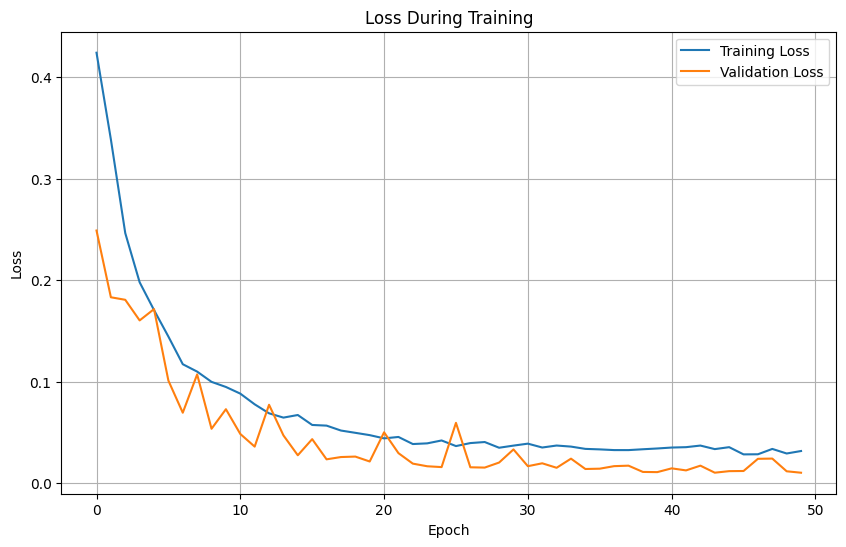

In [ ]:
# Visualisasi Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Model forecast

In [ ]:
# Fungsi untuk memprediksi menggunakan model
def model_forecast(model, data, window_size):
    forecast = []
    for time in range(len(data) - window_size):
        forecast.append(model.predict(data[time:time + window_size][np.newaxis]))
    return np.array(forecast).squeeze()

In [ ]:
# Compute the forecast for the validation dataset. Remember you need the last WINDOW SIZE values to make the first prediction
rnn_forecast = model_forecast(model, FEATURES[SPLIT_TIME-WINDOW_SIZE:], WINDOW_SIZE)

# Denormalisasi prediksi dan data validasi
rnn_forecast[:, 0] = rnn_forecast[:, 0] * std_low + mean_low  # Denormalisasi low
rnn_forecast[:, 1] = rnn_forecast[:, 1] * std_high + mean_high  # Denormalisasi high
rnn_forecast[:, 2] = rnn_forecast[:, 2] * std_close + mean_close  # Denormalisasi close

# Denormalisasi data validasi
series_valid_denorm = features_valid * np.array([std_low, std_high, std_close]) + np.array([mean_low, mean_high, mean_close])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━

In [ ]:
print(f"time_valid shape: {time_valid.shape}")
print(f"series_valid_denorm shape: {series_valid_denorm.shape}")
print(f"rnn_forecast shape: {rnn_forecast.shape}")


time_valid shape: (1115,)
series_valid_denorm shape: (1115, 3)
rnn_forecast shape: (1115, 3)


Visualize the forecast

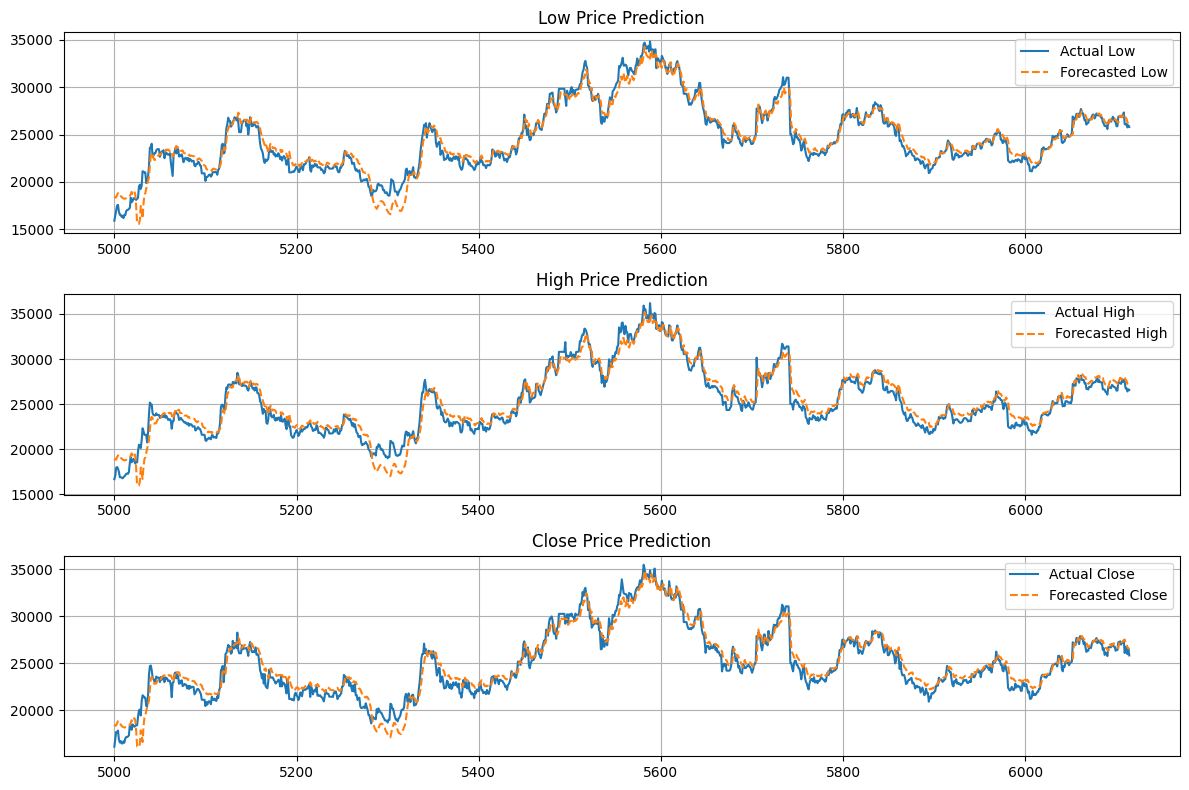

In [ ]:
# Visualisasi hasil prediksi
plt.figure(figsize=(12, 8))

# Plot 'low'
plt.subplot(3, 1, 1)
plt.plot(time_valid, series_valid_denorm[:, 0], label='Actual Low')
plt.plot(time_valid, rnn_forecast[:, 0], label='Forecasted Low', linestyle='--')
plt.title('Low Price Prediction')
plt.legend()
plt.grid(True)

# Plot 'high'
plt.subplot(3, 1, 2)
plt.plot(time_valid, series_valid_denorm[:, 1], label='Actual High')
plt.plot(time_valid, rnn_forecast[:, 1], label='Forecasted High', linestyle='--')
plt.title('High Price Prediction')
plt.legend()
plt.grid(True)

# Plot 'close'
plt.subplot(3, 1, 3)
plt.plot(time_valid, series_valid_denorm[:, 2], label='Actual Close')
plt.plot(time_valid, rnn_forecast[:, 2], label='Forecasted Close', linestyle='--')
plt.title('Close Price Prediction')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
def compute_metrics(true_series, forecast):
    """Computes MSE and MAE metrics for the forecast"""
    mse = tf.keras.losses.MSE(true_series, forecast)
    mae = tf.keras.losses.MAE(true_series, forecast)
    return mse, mae


In [ ]:
mse, mae = compute_metrics(series_valid_denorm, rnn_forecast)
print(f"mse: {mse.numpy().mean():.2f}, mae: {mae.numpy().mean():.2f} for forecast")


mse: 832438.44, mae: 695.76 for forecast


Pada konteks model regresi, "accuracy" biasanya tidak dihitung karena itu adalah metrik yang lebih umum digunakan untuk klasifikasi. Sebagai gantinya, metrik seperti Mean Squared Error (MSE) atau Mean Absolute Error (MAE) digunakan untuk mengevaluasi kinerja model regresi.

Namun, jika tetap ingin mencetak akurasi berdasarkan toleransi tertentu (misalnya, prediksi dianggap benar jika perbedaannya dengan nilai aktual berada dalam rentang tertentu), 

In [ ]:
def calculate_accuracy(true_values, predicted_values, tolerance=0.05):
    """
    Menghitung akurasi berdasarkan toleransi tertentu.
    Akurasi dihitung sebagai persentase prediksi yang berada dalam batas toleransi.

    Parameters:
    - true_values: Array nilai sebenarnya.
    - predicted_values: Array nilai prediksi.
    - tolerance: Toleransi absolut atau persentase untuk menentukan apakah prediksi benar.

    Returns:
    - Akurasi dalam persen.
    """
    differences = np.abs(true_values - predicted_values)
    within_tolerance = differences <= (tolerance * true_values)
    accuracy = np.mean(within_tolerance) * 100  # Menghitung persentase
    return accuracy


In [ ]:
# Hitung akurasi
tolerance = 0.05
accuracy = calculate_accuracy(series_valid_denorm, rnn_forecast, tolerance=tolerance)

print(f"Akurasi model (dengan toleransi {tolerance*100:.1f}%): {accuracy:.2f}%")

Akurasi model (dengan toleransi 5.0%): 85.50%


Future Forecast

In [ ]:
# Fungsi untuk memprediksi harga saham di masa depan
def forecast_future(model, series, last_known_time, last_known_date, window_size, days_to_forecast):
    """
    Generate future stock price predictions for a specified number of days.

    Parameters:
    - model: Trained TensorFlow model.
    - series: The known time series data.
    - last_known_time: The time index of the last known data point.
    - last_known_date: The date of the last known data point.
    - window_size: The size of the input window for the model.
    - days_to_forecast: The number of future days to predict.

    Returns:
    - future_dates: List of future dates.
    - future_forecast: Predicted stock prices for the future dates.
    """
    future_forecast = []
    current_window = series[-window_size:]  # Ambil window terakhir dari data yang diketahui
    current_window = current_window[np.newaxis, :, :]  # Tambahkan batch dimension

    future_dates = [last_known_date + timedelta(days=i) for i in range(1, days_to_forecast + 1)]

    for _ in range(days_to_forecast):
        prediction = model.predict(current_window, verbose=0).squeeze()

        # Denormalisasi prediksi
        denormalized_prediction = [
            prediction[0] * std_low + mean_low,  # Denormalisasi low
            prediction[1] * std_high + mean_high,  # Denormalisasi high
            prediction[2] * std_close + mean_close  # Denormalisasi close
        ]
        future_forecast.append(denormalized_prediction)

        # Normalisasi kembali prediksi untuk digunakan dalam window berikutnya
        normalized_prediction = [
            (denormalized_prediction[0] - mean_low) / std_low,
            (denormalized_prediction[1] - mean_high) / std_high,
            (denormalized_prediction[2] - mean_close) / std_close
        ]
        normalized_prediction = np.array(normalized_prediction)

        # Geser window dan tambahkan prediksi terbaru
        current_window = np.append(current_window[:, 1:, :], [[normalized_prediction]], axis=1)

    return future_dates, np.array(future_forecast)


In [ ]:
# Define the last known date and time index from your dataset
last_known_date = datetime.strptime("2024-11-18", "%Y-%m-%d")
last_known_time = TIME[-1]  # Indeks waktu terakhir pada dataset

In [ ]:
# Predict future prices 
days_to_forecast = (datetime.strptime("2024-11-25", "%Y-%m-%d") - last_known_date).days

# Melakukan prediksi harga saham untuk beberapa hari ke depan
future_dates, future_forecast = forecast_future(
    model, FEATURES, last_known_time, last_known_date, WINDOW_SIZE, days_to_forecast
)


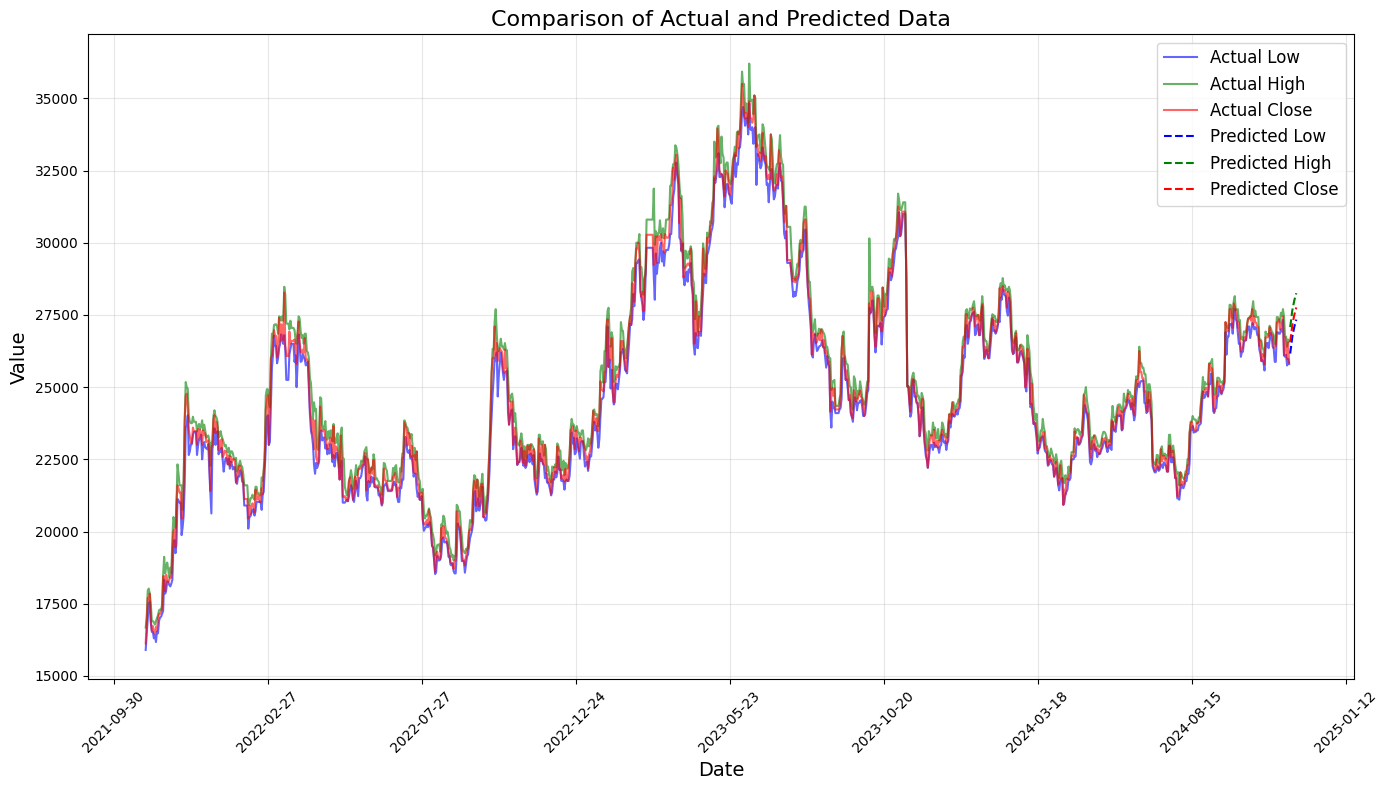

In [ ]:
# Gabungkan data asli dan prediksi dengan DateTimeIndex
historical_dates = [last_known_date - timedelta(days=i) for i in range(len(series_valid_denorm))][::-1]
historical_data = pd.DataFrame({
    'Date': historical_dates,
    'Low': series_valid_denorm[:, 0],
    'High': series_valid_denorm[:, 1],
    'Close': series_valid_denorm[:, 2]
}).set_index('Date')

predicted_df = pd.DataFrame({
    'Date': future_dates[:len(future_forecast)],
    'Low': [forecast[0] for forecast in future_forecast],
    'High': [forecast[1] for forecast in future_forecast],
    'Close': [forecast[2] for forecast in future_forecast]
}).set_index('Date')

# Gabungkan data historis dan prediksi
combined_df = pd.concat([historical_data, predicted_df])

# Visualisasi perbandingan data historis dan prediksi
plt.figure(figsize=(14, 8))

# Plot data asli
plt.plot(historical_data.index, historical_data['Low'], label='Actual Low', color='blue', alpha=0.6)
plt.plot(historical_data.index, historical_data['High'], label='Actual High', color='green', alpha=0.6)
plt.plot(historical_data.index, historical_data['Close'], label='Actual Close', color='red', alpha=0.6)

# Plot data prediksi
plt.plot(predicted_df.index, predicted_df['Low'], label='Predicted Low', color='blue', linestyle='dashed')
plt.plot(predicted_df.index, predicted_df['High'], label='Predicted High', color='green', linestyle='dashed')
plt.plot(predicted_df.index, predicted_df['Close'], label='Predicted Close', color='red', linestyle='dashed')

# Konfigurasi sumbu waktu dan format tanggal
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))  # Maksimum 10 label x-axis
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
plt.gca().tick_params(axis='x', rotation=45)

# Tambahkan judul, label sumbu, dan legenda
plt.title('Comparison of Actual and Predicted Data', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)

# Tampilkan grafik
plt.tight_layout()
plt.show()

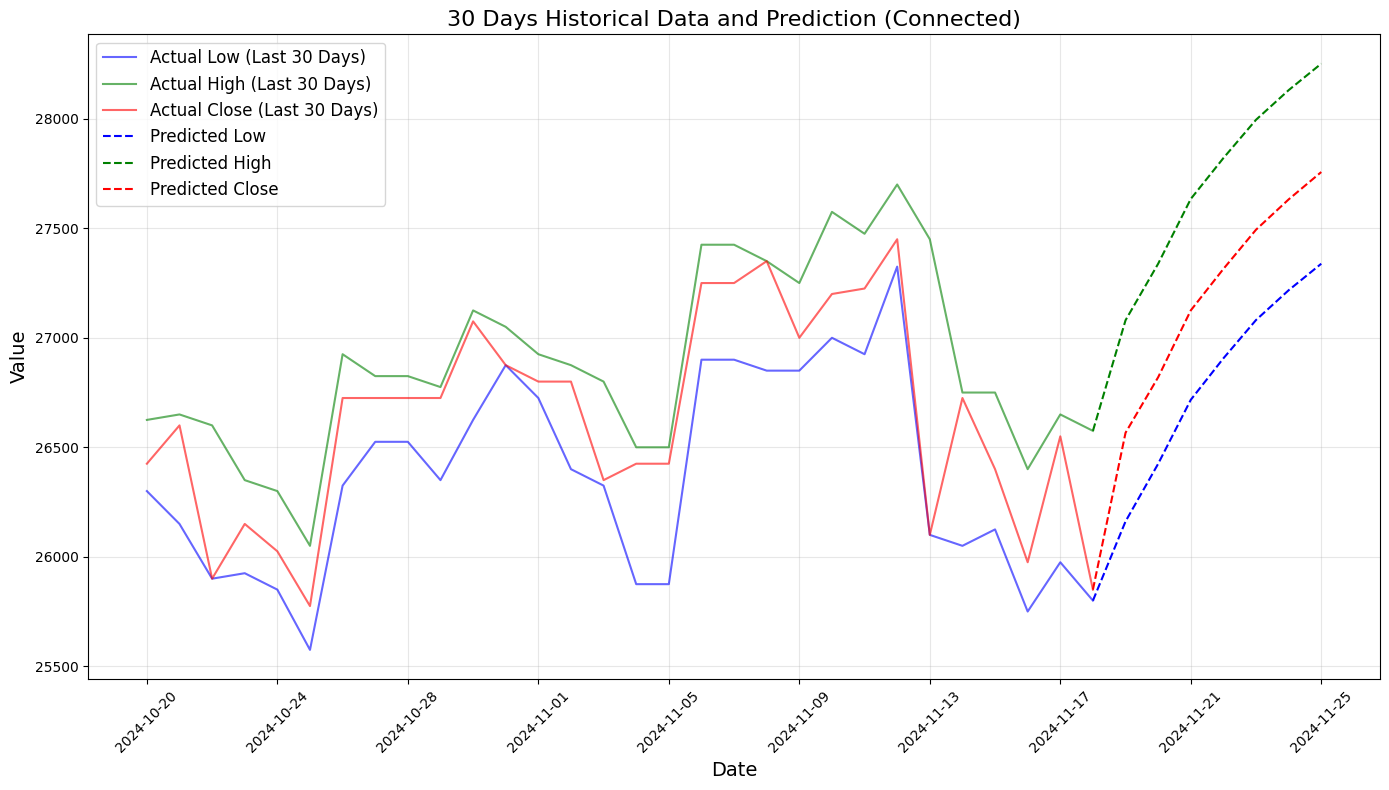

In [ ]:
# Ambil 30 hari terakhir dari data historis
historical_last_30 = historical_data.tail(30)

# Ambil titik terakhir dari data historis
last_historical_point = historical_last_30.iloc[-1]

# Tambahkan titik terakhir data historis ke awal data prediksi
predicted_df_with_connection = pd.concat([pd.DataFrame([last_historical_point]), predicted_df])

# Gabungkan data historis (30 hari terakhir) dengan prediksi
combined_last_30_and_forecast = pd.concat([historical_last_30, predicted_df_with_connection])

# Plot data historis (30 hari terakhir)
plt.figure(figsize=(14, 8))
plt.plot(historical_last_30.index, historical_last_30['Low'], label='Actual Low (Last 30 Days)', color='blue', alpha=0.6)
plt.plot(historical_last_30.index, historical_last_30['High'], label='Actual High (Last 30 Days)', color='green', alpha=0.6)
plt.plot(historical_last_30.index, historical_last_30['Close'], label='Actual Close (Last 30 Days)', color='red', alpha=0.6)

# Plot data prediksi
plt.plot(predicted_df_with_connection.index, predicted_df_with_connection['Low'], label='Predicted Low', color='blue', linestyle='dashed')
plt.plot(predicted_df_with_connection.index, predicted_df_with_connection['High'], label='Predicted High', color='green', linestyle='dashed')
plt.plot(predicted_df_with_connection.index, predicted_df_with_connection['Close'], label='Predicted Close', color='red', linestyle='dashed')

# Konfigurasi sumbu waktu dan format tanggal
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))  # Maksimum 10 label x-axis
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
plt.gca().tick_params(axis='x', rotation=45)

# Tambahkan judul, label sumbu, dan legenda
plt.title('30 Days Historical Data and Prediction (Connected)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)

# Tampilkan grafik
plt.tight_layout()
plt.show()

In [ ]:
# Cetak prediksi masa depan untuk masing-masing variabel beserta tanggalnya
print("Future Predictions:")
print("=" * 50)
print(f"{'Date':<15}{'Low':<15}{'High':<15}{'Close':<15}")
print("=" * 50)

for date, forecast in zip(future_dates, future_forecast):
    print(f"{date.strftime('%Y-%m-%d'):<15}{forecast[0]:<15.2f}{forecast[1]:<15.2f}{forecast[2]:<15.2f}")


Future Predictions:
Date           Low            High           Close          
2024-11-19     26161.57       27080.17       26566.37       
2024-11-20     26424.77       27338.35       26820.00       
2024-11-21     26716.93       27634.19       27125.22       
2024-11-22     26906.24       27820.73       27314.55       
2024-11-23     27081.23       27995.60       27493.67       
2024-11-24     27217.18       28130.88       27631.95       
2024-11-25     27338.28       28251.88       27757.00       


In [ ]:
# Menyimpan model dalam format HDF5
model.save('model.h5')